In [186]:
%matplotlib inline

In [187]:
import pandas as pd
import matplotlib.pyplot as plt

import re

# Mental disorders analysis

## Introduction

## Plan
Although the project title is *Mental disorders analysis*, we are going to analize only a few like depression, anxiety and Obsessive Compulsive Disorder

Some words why I chose the datasets

At the beginning we are going to clean some datasets. Then we will proceed to make some hypotesis and prove or reject them. We are also going to compare results from multiple datasets.

Then we will try to train a model using Regression that will try to predict whether a person has any of the above mentioned disorders.

In the end, we will try to find typical behavior for those disorders and then map compare it to other disorders.

## Data Cleanup

Let's begin by creating a function that will be used for renaming columns to snake_case

In [188]:
def to_snake_case(col_name):
    col_name = col_name.strip()
    col_name = col_name.lower()
    col_name = re.sub(r"[^\w\s]", "_", col_name) # replace non-alphanumeric characters with underscores
    col_name = re.sub(r"\s+", "_", col_name) # regex is used instead of replace to handle multiple spaces
    col_name = re.sub(r"_+", "_", col_name)  # replace multiple underscores with a single underscore
    col_name = col_name.rstrip("_")

    return col_name

Let's start with the Student Depression Dataset.csv dataset.

In [189]:
student_depression_data = pd.read_csv('data/Student Depression Dataset.csv')

In [190]:
student_depression_data

,id,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,2,Male,33.0,Visakhapatnam,Student,5.0,0.0,8.97,2.0,0.0,5-6 hours,Healthy,B.Pharm,Yes,3.0,1.0,No,1
1,8,Female,24.0,Bangalore,Student,2.0,0.0,5.90,5.0,0.0,5-6 hours,Moderate,BSc,No,3.0,2.0,Yes,0
2,26,Male,31.0,Srinagar,Student,3.0,0.0,7.03,5.0,0.0,Less than 5 hours,Healthy,BA,No,9.0,1.0,Yes,0
3,30,Female,28.0,Varanasi,Student,3.0,0.0,5.59,2.0,0.0,7-8 hours,Moderate,BCA,Yes,4.0,5.0,Yes,1
4,32,Female,25.0,Jaipur,Student,4.0,0.0,8.13,3.0,0.0,5-6 hours,Moderate,M.Tech,Yes,1.0,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,Female,27.0,Surat,Student,5.0,0.0,5.75,5.0,0.0,5-6 hours,Unhealthy,Class 12,Yes,7.0,1.0,Yes,0
27897,140686,Male,27.0,Ludhiana,Student,2.0,0.0,9.40,3.0,0.0,Less than 5 hours,Healthy,MSc,No,0.0,3.0,Yes,0
27898,140689,Male,31.0,Faridabad,Student,3.0,0.0,6.61,4.0,0.0,5-6 hours,Unhealthy,MD,No,12.0,2.0,No,0
27899,140690,Female,18.0,Ludhiana,Student,5.0,0.0,6.88,2.0,0.0,Less than 5 hours,Healthy,Class 12,Yes,10.0,5.0,No,1


In [191]:
student_depression_data.columns = [to_snake_case(c) for c in student_depression_data.columns]

First thing we notice is that the dataset contains a column named Profession. However, that column includes Student as a value. We also have Work/Study Hours.

In [193]:
profession_stats = student_depression_data.profession.value_counts().reset_index()
profession_stats.columns = ["Profession", "Count"]
profession_stats

,Profession,Count
0,Student,27870
1,Architect,8
2,Teacher,6
3,Digital Marketer,3
4,Chef,2
5,Content Writer,2
6,Pharmacist,2
7,Doctor,2
8,UX/UI Designer,1
9,Civil Engineer,1


The bar chart says it all :)

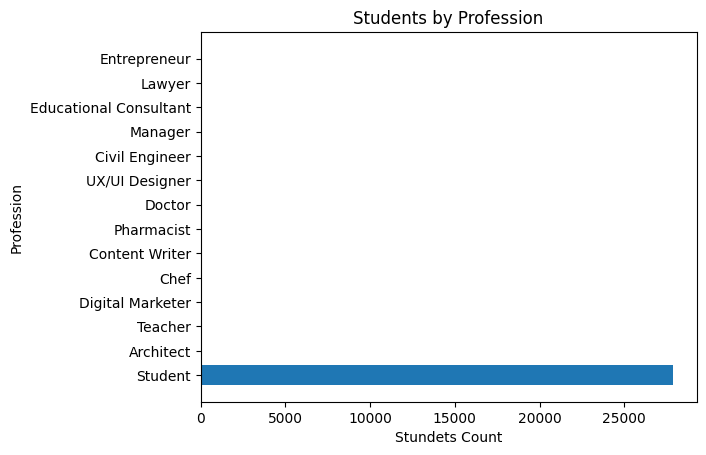

In [194]:
profession_stats = student_depression_data['profession'].value_counts()

professions = profession_stats.index
counts = profession_stats.values

plt.barh(professions, counts)
plt.title("Students by Profession")
plt.xlabel("Stundets Count")
plt.ylabel("Profession")

plt.show()

As the name of the dataset suggests, it is about student. Data also shows it by having too little of the ramaining values. That is why I am going to assume that any other profession is not usable for any hypothesis and any row that is not a student will be considered to be an outlier and therefore be removed.

In [195]:
student_depression_data = student_depression_data[student_depression_data.profession == "Student"]

Let's not forget to rename the Work/Study Hours (that now is work_study_hours) since it would not make sense otherwise

In [196]:
student_depression_data = student_depression_data.rename(columns={"work_study_hours": "study_hours"})

We can also see that there are very few students that have a value for the column Job Satisfaction. However, the profession is Student. These students could either be studying and working or only studying but since the value in the previously named column Work/Job Hours was in one place, I will assume that this data is redundant and could be deleted.

In [197]:
student_depression_data.job_satisfaction.value_counts()

job_satisfaction
0.0    27862
2.0        3
4.0        2
1.0        2
3.0        1
Name: count, dtype: int64

In [198]:
student_depression_data = student_depression_data[student_depression_data.job_satisfaction == 0]
student_depression_data = student_depression_data.drop(columns=["job_satisfaction"])

Here we can see that there are diferent values for Work Pressure and since we already decided to test only for students that are not employed, I am going to drop those that are equal to 0

In [199]:
student_depression_data.work_pressure.value_counts()

work_pressure
0.0    27862
Name: count, dtype: int64

In [200]:
student_depression_data = student_depression_data.drop(columns=["work_pressure"])

Since we removed all records where the Profession column has a value diferrent than Student we can remove the whole column since it does not bring any new knowledge

In [201]:
student_depression_data = student_depression_data.drop(columns=["profession"])

Now in order to be more consistent I will translate the values of the folowing columns to 0 and 1 instead of Yes or No:

Have you ever had suicidal thoughts ?
Family History of Mental Illness

And the gender column to:

Male = 0 and Female = 1

But let's first see if there are values that are not Yes or No and Male or Female

In [202]:
student_depression_data.have_you_ever_had_suicidal_thoughts = (student_depression_data.have_you_ever_had_suicidal_thoughts == "Yes").astype(int)
student_depression_data.family_history_of_mental_illness = (student_depression_data.family_history_of_mental_illness == "Yes").astype(int)
student_depression_data.gender = (student_depression_data.gender == "Male").astype(int)

This is what the dataset looks after the cleanup

In [203]:
student_depression_data

,id,gender,age,city,academic_pressure,cgpa,study_satisfaction,sleep_duration,dietary_habits,degree,have_you_ever_had_suicidal_thoughts,study_hours,financial_stress,family_history_of_mental_illness,depression
0,2,1,33.0,Visakhapatnam,5.0,8.97,2.0,5-6 hours,Healthy,B.Pharm,1,3.0,1.0,0,1
1,8,0,24.0,Bangalore,2.0,5.90,5.0,5-6 hours,Moderate,BSc,0,3.0,2.0,1,0
2,26,1,31.0,Srinagar,3.0,7.03,5.0,Less than 5 hours,Healthy,BA,0,9.0,1.0,1,0
3,30,0,28.0,Varanasi,3.0,5.59,2.0,7-8 hours,Moderate,BCA,1,4.0,5.0,1,1
4,32,0,25.0,Jaipur,4.0,8.13,3.0,5-6 hours,Moderate,M.Tech,1,1.0,1.0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,140685,0,27.0,Surat,5.0,5.75,5.0,5-6 hours,Unhealthy,Class 12,1,7.0,1.0,1,0
27897,140686,1,27.0,Ludhiana,2.0,9.40,3.0,Less than 5 hours,Healthy,MSc,0,0.0,3.0,1,0
27898,140689,1,31.0,Faridabad,3.0,6.61,4.0,5-6 hours,Unhealthy,MD,0,12.0,2.0,0,0
27899,140690,0,18.0,Ludhiana,5.0,6.88,2.0,Less than 5 hours,Healthy,Class 12,1,10.0,5.0,0,1


The dataset looks good. Let's now proceed with the second dataset about depression.

## Some hypothesis

### Hypothesis 01

### Hypothesis 02

### Hypothesis 03

### Hypothesis ...

### Hypothesis N

## Some more serious data science (Regression maybe)

## Sources

[Student Depression Dataset.](https://www.kaggle.com/datasets/hopesb/student-depression-dataset)

[Depression Dataset](https://www.kaggle.com/datasets/anthonytherrien/depression-dataset)

[Social Anxiety Dataset](https://www.kaggle.com/datasets/natezhang123/social-anxiety-dataset/data)

[Anxiety and Depression Mental Health Factors](https://www.kaggle.com/datasets/ak0212/anxiety-and-depression-mental-health-factors)

[OCD Patient Dataset: Demographics & Clinical Data](https://www.kaggle.com/datasets/ohinhaque/ocd-patient-dataset-demographics-and-clinical-data)

[OCD_Social_Media_Dataset](https://www.kaggle.com/datasets/bhagvendersingh/ocd-social-media-dataset)

[Mental Disorders Dataset](https://www.kaggle.com/datasets/baselbakeer/mental-disorders-dataset/data)